In [1]:
% matplotlib inline
from __future__ import (division, 
                        print_function)

import os
import sys
import copy
import fnmatch
import warnings
import collections

import numpy as np
import scipy
try:
    from scipy.stats import scoreatpercentile
except:
    scoreatpercentile = False
from scipy.interpolate import interp1d
import cPickle as pickle

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar
from astropy.convolution import convolve, Box1DKernel

# AstroML
from astroML.plotting import hist
from astroML.density_estimation import KNeighborsDensity
try:
    from sklearn.neighbors import KernelDensity
    use_sklearn_KDE = True
except:
    import warnings
    warnings.warn("KDE will be removed in astroML version 0.3.  Please "
                  "upgrade to scikit-learn 0.14+ and use "
                  "sklearn.neighbors.KernelDensity.", DeprecationWarning)
    from astroML.density_estimation import KDE
    use_sklearn_KDE = False
from sklearn.neighbors import KDTree
from sklearn.neighbors import BallTree

# Matplotlib related
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter
from matplotlib.collections import PatchCollection
tickFormat = FormatStrFormatter('$\mathbf{%g}$') 

# Personal
import hscUtils as hUtil
#import galSBP
import coaddCutoutGalfitSimple as gSimple 

# Cosmology
import cosmology
c=cosmology.Cosmo(H0=70.0, omega_m=0.3, omega_l=0.7, flat=1)

# Color map 
from palettable.colorbrewer.sequential import Greys_9, OrRd_9, Blues_9, Purples_9, YlGn_9
BLK = Greys_9.mpl_colormap
ORG = OrRd_9.mpl_colormap
BLU = Blues_9.mpl_colormap
GRN = YlGn_9.mpl_colormap
PUR = Purples_9.mpl_colormap

# Personal tools
from hscUtils import songPlotSetup, removeIsNullCol
from hscUtils import confidence_interval, ma_confidence_interval_1d, confidence_interval_1d

## Constants
# SDSS pivot wavelength 
sdss_u_pivot = 3551.0
sdss_g_pivot = 4686.0
sdss_r_pivot = 6165.0
sdss_i_pivot = 7481.0
sdss_z_pivot = 8931.0

# HSC pivot wavelength 
hsc_g_pivot = 4782.2
hsc_r_pivot = 6101.7 
hsc_i_pivot = 7648.0 
hsc_z_pivot = 8883.0
hsc_y_pivot = 9750.8

hscFiltWave = np.asarray([hsc_g_pivot, hsc_r_pivot, hsc_i_pivot, hsc_z_pivot, hsc_y_pivot])

"""
Absolute magnitude of the Sun in HSC filters
Right now, just use the DES filters
"""
SUN_G = 5.08
SUN_R = 4.62
SUN_I = 4.52
SUN_Z = 4.52
SUN_Y = 4.51

# Solar stellar metallicity 
Z_SUN = 0.02

# definitions for the axes
left, width    = 0.12, 0.66
right          = left + width 
bottom, height = 0.14, 0.85
bottom_h = left_h = left + width + 0.02
recScat = [left,   bottom, width, height]
recHist = [right,  bottom,  0.21, height]
SBP1 = [0.13, 0.12, 0.865, 0.30]
SBP2 = [0.13, 0.42, 0.865, 0.54]
EC1 = [0.135, 0.066, 0.862, 0.30]
EC2 = [0.135, 0.366, 0.862, 0.30]
EC3 = [0.135, 0.666, 0.862, 0.30]
REC = [0.12, 0.11, 0.87, 0.87]
COG1 = [0.143, 0.10, 0.850, 0.43]
COG2 = [0.143, 0.53, 0.850, 0.43]

# Universal RSMA array
RSMA_COMMON = np.arange(0.4, 4.2, 0.01)
EMPTY = (RSMA_COMMON * np.nan)

# Color 
BLUE0 = "#92c5de"
BLUE1 = "#0571b0"
RED0 = "#f4a582"
RED1 = "#ca0020"
PURPLE0 = '#af8dc3'
PURPLE1 = '#762a83'
BROWN0 = '#bf812d'
BROWN1 = '#543005'
GREEN0 = '#7fbf7b'
GREEN1 = '#1b7837'

# 3-sigma
SIGMA1 = 0.3173
SIGMA2 = 0.0455
SIGMA3 = 0.0027

/Users/song/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [9]:
def normProf(sma, sbp, minSma, maxSma, integrate=True, 
             divide=False): 
    """
    Naive method to normalize the profile. 
    
    Parameters: 
        sbp    : Array for surface brightness profile 
        sma    : Radius range 
        minSma : Minimum SMA
        maxSma   Maximum SMA
    """
    if integrate: 
        indInt = np.where(sma <= minSma)
        isoArea = (np.pi * (sma[indInt] ** 2.0))
        isoRing = np.append(isoArea[1], [isoArea[1:] - isoArea[:-1]])
        intNorm = (np.log10(np.nansum((10.0 ** sbp[indInt]) * isoRing)))
    else:
        intNorm = np.nanmedian(sbp[(sma >= minSma) & 
                                   (sma <= maxSma)])
        
    if divide: 
        return (sbp / intNorm)
    else:
        return (sbp - intNorm)
    
    

def pixKpc(redshift, pix=0.168, show=True, npix=1.0):
    """
    Get the corresponding Kpc size of a pixel.  
    
    Parameters: 
    """
    pixKpc = pix * npix * hUtil.cosmoScale(redshift)

    if show:
        print("# %d pixel(s) = %6.3f Kpc" % (npix, pixKpc))
        
    return pixKpc

def logAdd(para1, para2):
    """ Useful for adding magnitudes. """
    return np.log10((10.0 ** np.asarray(para1)) + 
                    (10.0 ** np.asarray(para2)))

def errAdd(err1, err2):
    """Add error quadral..."""
    return np.sqrt((err1 ** 2.0) + 
                   (err2 ** 2.0))

def toColorArr(array, bottom=None, top=None):
    """ 
    Convert a data array to "color array" (between 0 and 1). 
    
    Parameters:
        bottom, top  : 
    """
    data = copy.deepcopy(array)
    
    colorArr = ((data - np.nanmin(data)) / 
                (np.nanmax(data) - np.nanmin(data))) 
    colorArr[colorArr <= 0] = 0.0
    
    if bottom is not None: 
        colorArr += bottom
    
    return colorArr

def toSizeArr(array, bottom=None, top=None, maxSize=40):
    """ 
    Convert a data array to "size array". 
    
    Parameters:
        bottom, top  : 
    """
    data = copy.deepcopy(array)
    if top is not None:
        data[data >= top] = top
    if bottom is not None:
        data[data <= bottom] = bottom
        
    return ((data - np.nanmin(data)) / 
            (np.nanmax(data) - np.nanmin(data))) * maxSize

def getLuminosity(mag, redshift, extinction=None, 
                  amag_sun=None):
    """Get the absolute magnitude or luminosity."""
    distmod = hUtil.cosmoDistMod(redshift)
    absMag = (mag - distmod)
    if extinction is not None: 
        absMag -= extinction 
    if amag_sun is not None: 
        absMag = ((amag_sun - absMag) / 2.5)
    
    return absMag

def getStackProfiles(sample, loc, name='GAMA', 
                     idCol='ID_USE', tabCol='sum_tab', save=True,
                     sedMod='fsps1'):
    """Get the stacks of the profiles."""
    print("## Sample %s : Will deal with %d galaxies" % (name, len(sample)))
    profiles = []
    with ProgressBar(len(sample), ipython_widget=True) as bar:
        for g in sample:
            try:
                gFile = os.path.join(loc, os.path.basename(g['sum_tab'].replace('./', '')).strip())
                gProf = Table.read(gFile, format='fits')
                """ Add extra information """
                #try: 
                gProf.meta['KCORRECT_I'] = g['KCORRECT_I']
                gProf.meta['KCORRECT_G'] = g['KCORRECT_G']
                gProf.meta['KCORRECT_R'] = g['KCORRECT_R']
                gProf.meta['KCORRECT_Z'] = g['KCORRECT_Z']
                gProf.meta['KCORRECT_Y'] = g['KCORRECT_Y']
                gProf.meta['LOGM2LI'] = g['LOGM2L_I_OBS']
                gProf.meta['LOGM2LG'] = g['LOGM2L_G_OBS']
                gProf.meta['LOGM2LR'] = g['LOGM2L_R_OBS']
                gProf.meta['LOGM2LZ'] = g['LOGM2L_Z_OBS']
                gProf.meta['LUM_10'] = g['lum_10']
                gProf.meta['LUM_15'] = g['lum_15']
                gProf.meta['LUM_25'] = g['lum_25']
                gProf.meta['LUM_30'] = g['lum_30']
                gProf.meta['LUM_40'] = g['lum_40']
                gProf.meta['LUM_50'] = g['lum_50']
                gProf.meta['LUM_60'] = g['lum_60']
                gProf.meta['LUM_75'] = g['lum_75']
                gProf.meta['LUM_100'] = g['lum_100']
                gProf.meta['LUM_120'] = g['lum_120']
                gProf.meta['LUM_150'] = g['lum_150']
                gProf.meta['LUM_MAX'] = g['lum_max']
                gProf.meta['R20_100'] = g['r20_100']
                gProf.meta['R50_100'] = g['r50_100']
                gProf.meta['R80_100'] = g['r80_100']
                gProf.meta['LOGM_10'] = g['logm_10']
                gProf.meta['LOGM_15'] = g['logm_15']
                gProf.meta['LOGM_25'] = g['logm_25']
                gProf.meta['LOGM_30'] = g['logm_30']
                gProf.meta['LOGM_40'] = g['logm_40']
                gProf.meta['LOGM_50'] = g['logm_50']
                gProf.meta['LOGM_60'] = g['logm_60']
                gProf.meta['LOGM_75'] = g['logm_75']
                gProf.meta['LOGM_100'] = g['logm_100']
                gProf.meta['LOGM_120'] = g['logm_120']
                gProf.meta['LOGM_150'] = g['logm_150']
                gProf.meta['LOGM_MAX'] = g['logm_max']
                #except Exception:
                #    print("## WARNING: Some metadata may not be available !")
                #    continue
            except Exception:
                print("## Missing: %s" % gFile)
                continue 
            profiles.append(gProf)
            bar.update()
    
    if save: 
        outPkl = os.path.join(loc, (name + '_profs.pkl'))
        hUtil.saveToPickle(profiles, outPkl)
        print("## Save %s to %s" % (name, outPkl))
        
    return profiles

def organizeSbp(profiles, col1='muI1', col2='KCORRECT_I', 
                kind='sbp', norm=False, r1=9.9, r2=10.1, divide=False,
                col3=None, col4=None, justStack=False, integrate=False,
                sun1=SUN_G, sun2=SUN_R, normArr=None,
                index=None, extCat=None):
    """ Get the stack of individual profiels, and their med/avg. """
    # Surface brightness profile / luminosity profiles
    if kind.strip() == 'sbp':
        if col2 is not None: 
            if norm:
                stack = np.vstack(normProf(p['rKpc'], 
                                           np.asarray(p[col1] + (p.meta[col2] / 2.5)), 
                                           r1, r2, divide=divide, integrate=integrate) 
                                  for p in profiles)
            else:
                stack = np.vstack(np.asarray(p[col1] + (p.meta[col2] / 2.5)) 
                                  for p in profiles)
        else: 
            print("## NO KCORRECTION APPLIED !!")            
            if norm:
                stack = np.vstack(normProf(p['rKpc'], p[col1], 
                                           r1, r2, divide=divide, integrate=integrate) 
                                  for p in profiles)
            else:
                stack = np.vstack(np.asarray(p[col1]) for p in profiles)
    # Mass profiles
    elif kind.strip() == 'mass':
        if norm and (normArr is None):
            stack = np.vstack(normProf(p['rKpc'], 
                                       np.asarray(p[col1] + p.meta[col2]), 
                                       r1, r2, divide=divide, integrate=integrate) 
                              for p in profiles)
        elif norm and (normArr is not None):
            stack = np.vstack((np.asarray(p[col1] + p.meta[col2]) - normArr[i]) for (i, p) 
                              in enumerate(profiles))
        else: 
            stack = np.vstack(np.asarray(p[col1] + p.meta[col2]) for p in profiles)
    # Color profiles
    elif kind.strip() == 'color':
        cSun = (sun1 - sun2)
        if col3 is None or col4 is None:
            print("## NO KCORRECTION APPLIED !!")
            if norm:
                stack = np.vstack(normProf(p['rKpc'], 
                                           np.asarray(cSun - 2.5 * (p[col1] - p[col2])), 
                                           r1, r2, divide=divide, integrate=integrate) 
                                  for p in profiles)
            else: 
                stack = np.vstack(np.asarray(cSun - 2.5 *(p[col1] - p[col2])) for p in profiles)
        else:
            if norm:
                stack = np.vstack(normProf(p['rKpc'], 
                                           np.asarray(cSun - 2.5 * (p[col1] - p[col2]) -
                                                      (p.meta[col3] - p.meta[col4])), 
                                           r1, r2, divide=divide, integrate=integrate) 
                                  for p in profiles)
            else: 
                stack = np.vstack(np.asarray(cSun - 2.5 * (p[col1] - p[col2]) -
                                             (p.meta[col3] - p.meta[col4])) 
                                  for p in profiles)
    # Luminosity or stellar mass curve of growth
    elif kind.strip() == 'cog':
        if col2 is None:
            # Luminosity
            if not norm:
                stack = np.vstack(np.asarray(p[col1]) for p in profiles)
            else:
                if col3 is None: 
                    print("# No col3 found! Will not normalize!")
                stack = np.vstack(np.asarray(p[col1] - p.meta[col3]) for p in profiles)
        else: 
            # Stellar mass
            if not norm:
                stack = np.vstack(np.asarray(p[col1] + p.meta[col2]) for p in profiles)
            else:
                if col3 is None: 
                    print("# No col3 found! Will not normalize!")
                stack = np.vstack(np.asarray(p[col1] + p.meta[col2] 
                                             - p.meta[col3]) for p in profiles)
    else: 
        raise Exception("## WRONG KIND !!")
        
    if index is not None: 
        stack = np.vstack(p[index] for p in stack)
        
    if not justStack:
        """ Get the median and 1-sigma confidence range """
        medProf = confidence_interval(stack, axis=0, alpha=np.asarray([SIGMA1, 1.0]), 
                                      metric=np.nanmedian, numResamples=1500, 
                                      interpolate=True) 
        avgProf = confidence_interval(stack, axis=0, alpha=np.asarray([SIGMA1, 1.0]), 
                                      metric=np.nanmean, numResamples=1500, 
                                      interpolate=False) 
        stdProf = confidence_interval(stack, axis=0, alpha=np.asarray([SIGMA1, 1.0]), 
                                      metric=np.nanstd, numResamples=1500, 
                                      interpolate=True) 
        return stack, medProf, avgProf, stdProf
    else: 
        return stack
    

def loadPkl(filename):
    try:
        import cPickle as pickle
    except:
        warnings.warn("## cPickle is not available!!")
        import pickle
    
    if os.path.isfile(filename):
        pklFile = open(filename, 'rb')
        data = pickle.load(pklFile)    
        pklFile.close()
    
        return data
    else: 
        warnings.warn("## Can not find %s, return None" % filename)
        return None
    
    
    

def updateKcorrect(cat, zCol='z_use', magType='mag_cmodel',
                   filters=['g', 'r', 'i', 'z', 'y']):
    """Update the K-correction for each band."""
    cat = copy.deepcopy(cat)
    for f in filters:
        magCol = f + magType
        extCol = 'a_' + f
        absCol = 'ABSMAG_' + f.upper()
        kcorCol = 'KCORRECT_' + f.upper()
        newKcor = getLuminosity(cat[magCol], cat[zCol], 
                                extinction=cat[extCol]) - cat[absCol]
        try: 
            cat[kcorCol] = newKcor
        except Exception:
            cat.add_column(Column(newKcor, name=kcorCol))
            
    return cat

def updateMass(cat, m2l='LOGM2L_I_OBS', 
               apertures = ['5', '10', '15', '25', '30', '40', 
                            '50', '60', '75', '100', '120', 
                            '150', 'max']):
    """Update the stellar masses at each aperture."""
    cat = copy.deepcopy(cat)
    for aper in apertures:
        try:
            cat.add_column(Column(cat['lum_' + aper] + cat[m2l], 
                                  name=('logm_' + aper)))
        except Exception:
            print("## Can not update mass for lum_%s" % aper)
            
    return cat

def kdtreeMatch(sample1, sample2, name='kdmatched',
                mlim1=11.50, mlim2=12.0, zlim1=0.20, zlim2=0.50, 
                massCol='logm_100', zCol='z_use', 
                k1=5, k2=5, k3=5, k4=5, leaf=7,
                lamLimit=None, lamCol='lambda_redm', 
                pcenLimit=None, pcenCol='p_cen_1_redm', 
                massCut=None, zCut=None, 
                massMargin1=0.005, massMargin2=0.010, 
                zMargin1=-0.01, zMargin2=-0.005, 
                plot=True, save=True, folder=None, 
                unique=True, ballTree=False, metric='l1', 
                figX=12, figY=18, 
                mmin=11.21, mmax=12.3, zmin=0.19, zmax=0.51, 
                sizeCol='logm_10', minSize=10.4,
                colorCol='lambda_redm', minColor=20, maxColor=65,
                xLabel='$\mathrm{Redshift}$', 
                yLabel='$\log\ (M_{\star}/M_{\odot})\ (100\ \mathrm{Kpc})$', 
                legend1='$\Lambda \leq 20\ \mathrm{Cen}$',
                legend2='$\Lambda > %d\ \mathrm{Cen}$',
                legend3='$\Lambda \leq 20\ \mathrm{Cen;\ Matched}$',
                massKernel=0.06, zKernel=0.025,
                prefix1='redBCG', prefix2='nonBCG',
                mErrCol='MSTAR_ERR', mass2=None, figDir=None,
                color1a=BLK(0.4), color1b=BLK(0.7), cmap1=BLK, 
                color2a=ORG(0.4), color2b=ORG(0.7), cmap2=ORG, 
                xtickFormat='$\mathbf{%g}$', ytickFormat='$\mathbf{%g}$',
                showRegion=True, onlyUnique=True):
    """Match two samples using K-Dtree."""
    # Sample1 used for matching (should be the smaller one, e.g. the redBCG)
    sampleUse1 = sample1[(sample1[massCol] >= mlim1) & 
                         (sample1[massCol] <= mlim2) & 
                         (sample1[zCol] >= zlim1) &
                         (sample1[zCol] <= zlim2)]
    # Additional parameter cut: By default is Lambda and P_CEN
    if lamLimit is not None:
        sampleUse1 = sampleUse1[(sampleUse1[lamCol] >= lamLimit)]
    if pcenLimit is not None:
        sampleUse1 = sampleUse1[(sampleUse1[pcenCol] >= pcenLimit)]
    
    print("# Sample 1 Size: ", len(sampleUse1))

    ## Sample2 used for matching (the larger sample)
    sampleUse2 = sample2[(sample2[massCol] >= (mlim1 + massMargin1)) & 
                         (sample2[massCol] <= (mlim2 + massMargin2)) & 
                         (sample2[zCol] >= (zlim1 + zMargin1)) &
                         (sample2[zCol] <= (zlim2 + zMargin2))]
    print("# Sample 2 Size: ", len(sampleUse2))
    

    ## Isolate the parameters used for matching 
    if mass2 is None:
        data2 = np.stack((np.asarray(sampleUse2[massCol]), 
                          np.asarray(sampleUse2[zCol])), axis=-1)
    else:
        data2 = np.stack((np.asarray(sampleUse2[massCol]), 
                          np.asarray(sampleUse2[mass2]),
                          np.asarray(sampleUse2[zCol])), axis=-1)
        
    if not BallTree: 
        dataTree = KDTree(data2, leaf_size=leaf, metric=metric)
    else: 
        dataTree = BallTree(data2, leaf_size=leaf, metric=metric)
        
    if massCut is None and zCut is None:
        if mass2 is None:
            data1 = np.stack((np.asarray(sampleUse1[massCol]), 
                              np.asarray(sampleUse1[zCol])), axis=-1)
        else:
            data1 = np.stack((np.asarray(sampleUse1[massCol]), 
                              np.asarray(sampleUse2[mass2]),
                              np.asarray(sampleUse1[zCol])), axis=-1)
        dist, indAll = dataTree.query(data1, k=k1)
        indAll = indAll.ravel()
    elif massCut is not None and zCut is None:   
        if mass2 is None:
            data1a = np.stack((np.asarray(sampleUse1[sampleUse1[massCol] <= massCut][massCol]), 
                               np.asarray(sampleUse1[sampleUse1[massCol] <= massCut][zCol])), axis=-1)
            data1b = np.stack((np.asarray(sampleUse1[sampleUse1[massCol] > massCut][massCol]), 
                               np.asarray(sampleUse1[sampleUse1[massCol] > massCut][zCol])), axis=-1)
        else:
            data1a = np.stack((np.asarray(sampleUse1[sampleUse1[massCol] <= massCut][massCol]), 
                               np.asarray(sampleUse1[sampleUse1[massCol] <= massCut][mass2]),
                               np.asarray(sampleUse1[sampleUse1[massCol] <= massCut][zCol])), axis=-1)
            data1b = np.stack((np.asarray(sampleUse1[sampleUse1[massCol] > massCut][massCol]), 
                               np.asarray(sampleUse1[sampleUse1[massCol] > massCut][mass2]),
                               np.asarray(sampleUse1[sampleUse1[massCol] > massCut][zCol])), axis=-1)
        dist1, ind1 = dataTree.query(data1a, k=k1)
        dist2, ind2 = dataTree.query(data1b, k=k2)
        indAll = np.hstack([ind1.ravel(), ind2.ravel()])
    elif massCut is None and zCut is not None:   
        if mass2 is None:
            data1a = np.stack((np.asarray(sampleUse1[sampleUse1[zCol] <= zCut][massCol]), 
                               np.asarray(sampleUse1[sampleUse1[zCol] <= zCut][zCol])), axis=-1)
            data1b = np.stack((np.asarray(sampleUse1[sampleUse1[zCol] > zCut][massCol]), 
                               np.asarray(sampleUse1[sampleUse1[zCol] > zCut][zCol])), axis=-1)
        else:
            data1a = np.stack((np.asarray(sampleUse1[sampleUse1[zCol] <= zCut][massCol]), 
                               np.asarray(sampleUse1[sampleUse1[zCol] <= zCut][mass2]),
                               np.asarray(sampleUse1[sampleUse1[zCol] <= zCut][zCol])), axis=-1)
            data1b = np.stack((np.asarray(sampleUse1[sampleUse1[zCol] > zCut][massCol]), 
                               np.asarray(sampleUse1[sampleUse1[zCol] > zCut][mass2]),
                               np.asarray(sampleUse1[sampleUse1[zCol] > zCut][zCol])), axis=-1)
        dist1, ind1 = dataTree.query(data1a, k=k1)
        dist2, ind2 = dataTree.query(data1b, k=k2)
        indAll = np.hstack([ind1.ravel(), ind2.ravel()])
    else:
        if mass2 is None:
            data1a = np.stack((np.asarray(sampleUse1[(sampleUse1[zCol] <= zCut) & 
                                                     (sampleUse1[massCol] <= massCut)][massCol]), 
                               np.asarray(sampleUse1[(sampleUse1[zCol] <= zCut) & 
                                                     (sampleUse1[massCol] <= massCut)][zCol])), axis=-1)
            data1b = np.stack((np.asarray(sampleUse1[(sampleUse1[zCol] <= zCut) & 
                                                     (sampleUse1[massCol] > massCut)][massCol]), 
                               np.asarray(sampleUse1[(sampleUse1[zCol] <= zCut) & 
                                                     (sampleUse1[massCol] > massCut)][zCol])), axis=-1)
            data1c = np.stack((np.asarray(sampleUse1[(sampleUse1[zCol] > zCut) & 
                                                     (sampleUse1[massCol] <= massCut)][massCol]), 
                               np.asarray(sampleUse1[(sampleUse1[zCol] > zCut) & 
                                                     (sampleUse1[massCol] <= massCut)][zCol])), axis=-1)
            data1d = np.stack((np.asarray(sampleUse1[(sampleUse1[zCol] > zCut) & 
                                                     (sampleUse1[massCol] > massCut)][massCol]), 
                               np.asarray(sampleUse1[(sampleUse1[zCol] > zCut) & 
                                                     (sampleUse1[massCol] > massCut)][zCol])), axis=-1)
        else:
            data1a = np.stack((np.asarray(sampleUse1[(sampleUse1[zCol] <= zCut) & 
                                                     (sampleUse1[massCol] <= massCut)][massCol]), 
                               np.asarray(sampleUse1[(sampleUse1[zCol] <= zCut) & 
                                                     (sampleUse1[massCol] <= massCut)][mass2]),
                               np.asarray(sampleUse1[(sampleUse1[zCol] <= zCut) & 
                                                     (sampleUse1[massCol] <= massCut)][zCol])), axis=-1)
            data1b = np.stack((np.asarray(sampleUse1[(sampleUse1[zCol] <= zCut) & 
                                                     (sampleUse1[massCol] > massCut)][massCol]), 
                               np.asarray(sampleUse1[(sampleUse1[zCol] <= zCut) & 
                                                     (sampleUse1[massCol] > massCut)][mass2]),
                               np.asarray(sampleUse1[(sampleUse1[zCol] <= zCut) & 
                                                     (sampleUse1[massCol] > massCut)][zCol])), axis=-1)
            data1c = np.stack((np.asarray(sampleUse1[(sampleUse1[zCol] > zCut) & 
                                                     (sampleUse1[massCol] <= massCut)][massCol]), 
                               np.asarray(sampleUse1[(sampleUse1[zCol] > zCut) & 
                                                     (sampleUse1[massCol] <= massCut)][mass2]),
                               np.asarray(sampleUse1[(sampleUse1[zCol] > zCut) & 
                                                     (sampleUse1[massCol] <= massCut)][zCol])), axis=-1)
            data1d = np.stack((np.asarray(sampleUse1[(sampleUse1[zCol] > zCut) & 
                                                     (sampleUse1[massCol] > massCut)][massCol]), 
                               np.asarray(sampleUse1[(sampleUse1[zCol] > zCut) & 
                                                     (sampleUse1[massCol] > massCut)][mass2]),
                               np.asarray(sampleUse1[(sampleUse1[zCol] > zCut) & 
                                                     (sampleUse1[massCol] > massCut)][zCol])), axis=-1)
        dist1, ind1 = dataTree.query(data1a, k=k1)
        dist2, ind2 = dataTree.query(data1b, k=k2)
        dist3, ind3 = dataTree.query(data1c, k=k3)
        dist4, ind4 = dataTree.query(data1d, k=k4)
        indAll = np.hstack([ind1.ravel(), ind2.ravel(), ind3.ravel(), ind4.ravel()])
    
    ## Unique elements: 
    indUnique = np.unique(indAll)
    print("# All and Unique Matched Sample", len(indAll), len(indUnique))

    ## Matched samples: 
    sampleMatchA = sampleUse2[indAll]
    sampleMatchU = sampleUse2[indUnique]
    
    ## Save results: 
    if folder is None:
            folder = './'
    if save:
        sampleUse1.write(os.path.join(folder, prefix1 + '_' + name + '.fits'), 
                         format='fits', overwrite=True)
        if unique:
            sampleMatchU.write(os.path.join(folder, prefix2 + '_' + name + '.fits'), 
                               format='fits', overwrite=True)
        else:
            sampleMatchA.write(os.path.join(folder, prefix2 + '_' + name + '.fits'), 
                               format='fits', overwrite=True)

    ## Plot, now the plots are by default used for redBCG-nonBCG match
    if plot:
        fig1 = plt.figure(figsize=(figX, figY))
        fig1.subplots_adjust(left=0.12, right=0.985, wspace=0.05,
                             bottom=0.05, top=0.995, hspace=0.24)

        mx = np.linspace(mmin, mmax, 100)
        zx = np.linspace(zmin, zmax, 100)

        # Redshift - Mass plot 
        ax1 = fig1.add_subplot(311)
        ax1 = songPlotSetup(ax1, xtickFormat='$\mathbf{%5.2f}$', ytickFormat=ytickFormat)

        ## Mass limits 
        if showRegion:
            ax1.fill_between([zlim1, zlim2], [mlim1, mlim1], [mlim2, mlim2],
                             facecolor=cmap1(0.4), edgecolor=cmap1(0.4), alpha=0.4, 
                             zorder=0)

        ## Sample2
        p1 = ax1.scatter(sample2[zCol], sample2[massCol], 
                         alpha=0.30, facecolor=color1a, edgecolor='none', 
                         label=legend1, zorder=1)
        ## Sample1 
        p2 = ax1.scatter(sample1[zCol], sample1[massCol], 
                         facecolor='none', s=((sample1[sizeCol] - minSize) * 100.0), 
                         cmap=cmap2, alpha=0.60, marker='s', linewidth=2.0,
                         edgecolor=color2a, label=None)
        if lamLimit is None: 
            lamLimUse = 20
        else:
            lamLimUse = lamLimit
        p3 = ax1.scatter(sampleUse1[zCol], sampleUse1[massCol], 
                         edgecolor=color2b, 
                         s=((sampleUse1[sizeCol] - minSize) * 250.0), 
                         cmap=cmap2, alpha=1.00, 
                         c=sampleUse1[colorCol], 
                         label=legend2 % lamLimUse, marker='s', vmin=0.1)
        ## Matched GAMA sample
        p4 = ax1.scatter(sampleMatchU[zCol], sampleMatchU[massCol], 
                         alpha=0.50, facecolor=color1b, edgecolor='none', s=90,
                         label=legend3)

        ## Legend
        ax1.legend(loc=(0.62, 0.035), shadow=True, fancybox=True, 
                   numpoints=1, fontsize=22, scatterpoints=1, 
                   markerscale=0.9, borderpad=0.25, handletextpad=0.1)
        legend = ax1.get_legend()
        legend.legendHandles[1].set_color(color2b)
        legend.legendHandles[0].set_sizes([60])
        legend.legendHandles[0].set_alpha(0.8)
        legend.legendHandles[1].set_sizes([200])
        legend.legendHandles[2].set_sizes([150])

        ## Label
        ax1.set_xlabel(xLabel, size=28)
        ax1.set_ylabel(yLabel, size=25)

        ## Axis limits
        ax1.set_xlim(zmin, zmax)
        ax1.set_ylim((mmin - 0.44), mmax)

        # ------------------------------------------------------------------------------------------------------#
        # Mass Plot 
        ax2 = fig1.add_subplot(312)
        ax2 = songPlotSetup(ax2, xtickFormat=xtickFormat, ytickFormat=ytickFormat)

        ## KDE for sample 1
        sampleMKde = KernelDensity(massKernel, kernel='gaussian')
        sampleMKde.fit(sampleUse1[massCol][:, None])
        mDens1 = np.exp(sampleMKde.score_samples(mx[:, None]))

        ## KDE for sample 2
        sampleMKde = KernelDensity(massKernel, kernel='gaussian')
        sampleMKde.fit(sampleMatchA[massCol][:, None])
        mDens2A = np.exp(sampleMKde.score_samples(mx[:, None]))
        
        sampleMKde = KernelDensity(massKernel, kernel='gaussian')
        sampleMKde.fit(sampleMatchU[massCol][:, None])
        mDens2U = np.exp(sampleMKde.score_samples(mx[:, None]))

        ## Histogram 
        aa, _, _ = hist(sampleUse1[massCol], bins='knuth', ax=ax2, 
                        normed=True, zorder=1,
                        histtype='stepfilled', edgecolor='none', facecolor=color2b, 
                        alpha=0.5, label=legend2 % lamLimUse)
        bb, _, _ = hist(sampleMatchU[massCol], bins='knuth', ax=ax2, 
                        normed=True, zorder=1,
                        histtype='stepfilled', edgecolor='none', facecolor=color1b, 
                        alpha=0.3, label=legend3)

        ## Density plot 
        ax2.plot(mx, mDens1, '-', color=cmap2(0.8), zorder=3, linewidth=6.0, alpha=0.7)
        ax2.plot(mx, mDens2U, '-', color=cmap1(0.8), zorder=3, linewidth=4.0, alpha=0.7)
        if not onlyUnique:
            ax2.plot(mx, mDens2A, '--', color=cmap1(0.8), zorder=3, linewidth=3.0, alpha=0.5)

        ## X, Y Limits
        ax2.set_xlim(mmin, mmax)
        ylim = np.nanmax(np.hstack([aa, bb])) + 0.72
        ax2.set_ylim(0.02, ylim)

        ## Legend
        ax2.legend(loc=(0.590, 0.732), shadow=True, fancybox=True, 
                   numpoints=1, fontsize=24, scatterpoints=1, 
                   markerscale=1.2, borderpad=0.3, handletextpad=0.2)

        ## X, Y Lables
        ax2.set_xlabel(yLabel, size=26)
        ax2.set_ylabel('$\mathrm{Normalized\ \#}$', size=40)

        ## Highlight the median 
        ### sample 1
        ax2.plot([np.nanmedian(sampleUse1[massCol]), 
                  np.nanmedian(sampleUse1[massCol])],
                 [ylim-0.35, ylim-0.02], linewidth=5.0, c=cmap2(0.8))
        ax2.plot([np.percentile(sampleUse1[massCol], 25), 
                  np.percentile(sampleUse1[massCol], 25)],
                 [ylim-0.35, ylim-0.02], linewidth=5.0, c=cmap2(0.8), linestyle=':')
        ax2.plot([np.percentile(sampleUse1[massCol], 75), 
                  np.percentile(sampleUse1[massCol], 75)],
                 [ylim-0.35, ylim-0.02], linewidth=5.0, c=cmap2(0.8), linestyle=':')
        ### sample 2
        ax2.plot([np.nanmedian(sampleMatchU[massCol]), 
                  np.nanmedian(sampleMatchU[massCol])],
                 [ylim-0.70, ylim-0.37], linewidth=5.0, c=cmap1(0.8))
        ax2.plot([np.percentile(sampleMatchU[massCol], 25), 
                  np.percentile(sampleMatchU[massCol], 25)],
                 [ylim-0.70, ylim-0.37], linewidth=5.0, c=cmap1(0.8), linestyle=':')
        ax2.plot([np.percentile(sampleMatchU[massCol], 75), 
                  np.percentile(sampleMatchU[massCol], 75)],
                 [ylim-0.70, ylim-0.37], linewidth=5.0, c=cmap1(0.8), linestyle=':')
        ax2.yaxis.set_major_formatter(NullFormatter())

        # ------------------------------------------------------------------------------------------------------#
        # Redshift Plot 
        ax3 = fig1.add_subplot(313)
        ax3 = songPlotSetup(ax3, xtickFormat='$\mathbf{%5.2f}$', ytickFormat=ytickFormat)

        ## KDE for Sample1
        sampleMKde = KernelDensity(zKernel, kernel='gaussian')
        sampleMKde.fit(sampleUse1[zCol][:, None])
        zDens1 = np.exp(sampleMKde.score_samples(zx[:, None]))

        ## KDE for Sample2
        sampleMKde = KernelDensity(zKernel, kernel='gaussian')
        sampleMKde.fit(sampleMatchA[zCol][:, None])
        zDens2A = np.exp(sampleMKde.score_samples(zx[:, None]))

        sampleMKde = KernelDensity(zKernel, kernel='gaussian')
        sampleMKde.fit(sampleMatchU[zCol][:, None])
        zDens2U = np.exp(sampleMKde.score_samples(zx[:, None]))

        ## Histogram 
        aa, _, _ = hist(sampleUse1[zCol], bins='knuth', ax=ax3, normed=True, zorder=1,
                        histtype='stepfilled', edgecolor='none', facecolor=color2b, 
                        alpha=0.5)
        bb, _, _ = hist(sampleMatchU[zCol], bins='knuth', ax=ax3, normed=True, zorder=1,
                        histtype='stepfilled', edgecolor='none', facecolor=color1b, 
                        alpha=0.3)

        ## Density plot 
        ax3.plot(zx, zDens1, '-', color=cmap2(0.8), zorder=3, linewidth=6.0, alpha=0.7)
        ax3.plot(zx, zDens2U, '-', color=cmap1(0.8), zorder=3, linewidth=4.0, alpha=0.7)
        if not onlyUnique:
            ax3.plot(zx, zDens2A, '--', color=cmap1(0.8), zorder=3, linewidth=3.0, alpha=0.5)

        ## X, Y Limits
        ax3.set_xlim(zmin, zmax)
        ylim = np.nanmax(np.hstack([aa, bb])) + 0.72
        ax3.set_ylim(0.02, ylim)

        ## X, Y Lables
        ax3.set_xlabel(xLabel, size=28)
        ax3.set_ylabel('$\mathrm{Normalized\ \#}$', size=40)

        ## Highlight the median 
        ### Sample 1
        ax3.plot([np.nanmedian(sampleUse1[zCol]), 
                  np.nanmedian(sampleUse1[zCol])],
                 [ylim-0.35, ylim-0.02], linewidth=5.0, c=cmap2(0.9))
        ax3.plot([np.percentile(sampleUse1[zCol], 25), 
                  np.percentile(sampleUse1[zCol], 25)],
                 [ylim-0.35, ylim-0.02], linewidth=5.0, c=cmap2(0.9), linestyle=':')
        ax3.plot([np.percentile(sampleUse1[zCol], 75), 
                  np.percentile(sampleUse1[zCol], 75)],
                 [ylim-0.35, ylim-0.02], linewidth=5.0, c=cmap2(0.9), linestyle=':')
        ### Sample 2
        ax3.plot([np.nanmedian(sampleMatchU[zCol]), 
                  np.nanmedian(sampleMatchU[zCol])],
                 [ylim-0.70, ylim-0.37], linewidth=5.0, c=cmap1(0.9))
        ax3.plot([np.percentile(sampleMatchU[zCol], 25), 
                  np.percentile(sampleMatchU[zCol], 25)],
                 [ylim-0.70, ylim-0.37], linewidth=5.0, c=cmap1(0.9), linestyle=':')
        ax3.plot([np.percentile(sampleMatchU[zCol], 75), 
                  np.percentile(sampleMatchU[zCol], 75)],
                 [ylim-0.70, ylim-0.37], linewidth=5.0, c=cmap1(0.9), linestyle=':')
        ax3.yaxis.set_major_formatter(NullFormatter())
        # ------------------------------------------------------------------------------------------------------#
        plt.show()
        
        if figDir is not None:
            name = os.path.join(figDir, name)
        fig1.savefig(name + '_a.pdf', dpi=300)
    
    ## Return results
    if unique: 
        return sampleUse1, sampleMatchU
    else:
        return sampleUse1, sampleMatchA
    

def plotMassGrowth(parent1, parent2,
                   sample1a, sample1b, sample1c, 
                   sample2a, sample2b, sample2c, 
                   col1='logm_100', col2='logm_100', col3='logm_10', 
                   nResample=500, xSep1=11.55, xSep2=11.75, xSep3=11.95, 
                   lamLimit=30, pcenLimit=0.7, sizeCol1=None, sizeNorm=0.1,
                   colorCol1='z_use', colorLow=0.2, colorUpp=0.55, 
                   showBin1=True, showBin2=True, 
                   showHist1=False, showHist2=True, yKernel=0.05,
                   xMin=11.35, xMax=12.39, yMin=0.01, yMax=0.79,
                   xLabel='$\log\ (M_{\star}/M_{\odot})\ (100\ \mathrm{Kpc})$',
                   yLabel='$\Delta(\log M{\star})_{\mathrm{100\ kpc}-\mathrm{10\ kpc}}$',
                   outPng='mass_growth', save=True, outlineBin1=True,
                   color1a=BLK(0.2), color1b=BLK(0.6), cmap1=BLK, 
                   color2a=ORG(0.2), color2b=ORG(0.6), cmap2=ORG,
                   figDir=None, colorMin=None, colorMax=None,
                   xtickFormat='$\mathbf{%g}$', ytickFormat='$\mathbf{%g}$',
                   xLegend=0.68, yLegend=0.025):
    """Plot logM v.s. mass growth."""
    # Statistics of the two subsamples
    med_1ax = confidence_interval(sample1a[col1], axis=0, alpha=[SIGMA1, 1.0], 
                                  metric=np.nanmedian, numResamples=nResample, 
                                  interpolate=True)
    if col3 is not None:
        med_1ay = confidence_interval((sample1a[col2] - sample1a[col3]), 
                                      axis=0, alpha=[SIGMA1, 1.0], 
                                      metric=np.nanmedian, numResamples=nResample, 
                                      interpolate=True)
    else:
        med_1ay = confidence_interval(sample1a[col2], 
                                      axis=0, alpha=[SIGMA1, 1.0], 
                                      metric=np.nanmedian, numResamples=nResample, 
                                      interpolate=True)
    
    med_2ax = confidence_interval(sample2a[col1], axis=0, alpha=[SIGMA1, 1.0], 
                                  metric=np.nanmedian, numResamples=nResample, 
                                  interpolate=True)
    if col3 is not None:
        med_2ay = confidence_interval((sample2a[col2] - sample2a[col3]), 
                                      axis=0, alpha=[SIGMA1, 1.0], 
                                      metric=np.nanmedian, numResamples=nResample, 
                                      interpolate=True)
    else:
        med_2ay = confidence_interval(sample2a[col2], 
                                      axis=0, alpha=[SIGMA1, 1.0], 
                                      metric=np.nanmedian, numResamples=nResample, 
                                      interpolate=True)
    
    med_1bx = confidence_interval(sample1b[col1], axis=0, alpha=[SIGMA1, 1.0], 
                                  metric=np.nanmedian, numResamples=nResample, 
                                  interpolate=True)
    if col3 is not None:
        med_1by = confidence_interval((sample1b[col2] - sample1b[col3]), 
                                      axis=0, alpha=[SIGMA1, 1.0], 
                                      metric=np.nanmedian, numResamples=nResample, 
                                      interpolate=True)
    else:
        med_1by = confidence_interval(sample1b[col2], 
                                      axis=0, alpha=[SIGMA1, 1.0], 
                                      metric=np.nanmedian, numResamples=nResample, 
                                      interpolate=True)
    
    med_2bx = confidence_interval(sample2b[col1], axis=0, alpha=[SIGMA1, 1.0], 
                                  metric=np.nanmedian, numResamples=nResample, 
                                  interpolate=True)
    if col3 is not None:
        med_2by = confidence_interval((sample2b[col2] - sample2b[col3]), 
                                      axis=0, alpha=[SIGMA1, 1.0], 
                                      metric=np.nanmedian, numResamples=nResample, 
                                      interpolate=True)
    else:
        med_2by = confidence_interval(sample2b[col2], 
                                      axis=0, alpha=[SIGMA1, 1.0], 
                                      metric=np.nanmedian, numResamples=nResample, 
                                      interpolate=True)

    # ------------------------------------------------------------------------------------ #
    fig = plt.figure(figsize=(13, 9))
    ax1 = plt.axes(recScat)
    ax2 = plt.axes(recHist)
    ax1 = songPlotSetup(ax1, xtickFormat=xtickFormat, ytickFormat=ytickFormat)
    ax2 = songPlotSetup(ax2, xtickFormat=xtickFormat, ytickFormat=ytickFormat)

    # ---------------------------------------------------------------------------
    # Scatter plot
    ## Mass separation of two bins
    ax1.axvline(xSep1, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
    ax1.axvline(xSep2, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
    ax1.axvline(xSep3, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
    ## Horizontal line for 0.0
    ax1.axhline(0.0, linewidth=4.5, linestyle='-', c='k', alpha=0.2)
    
    # Parent samples 
    if col3 is not None:
        p1 = ax1.scatter(parent2[col1], 
                         parent2[col2] - parent2[col3], s=20.0, 
                         alpha=0.50, facecolor=color1a, edgecolor='none', 
                         label='$\Lambda \leq 20\ \mathrm{Cen;\ All}$')
    else:
        p1 = ax1.scatter(parent2[col1], 
                         parent2[col2], s=20.0, 
                         alpha=0.50, facecolor=color1a, edgecolor='none', 
                         label='$\Lambda \leq 20\ \mathrm{Cen;\ All}$')
    
    if sizeCol1 is None: 
        size1 = 200.0
    else:
        size1 = ((parent1[sizeCol1] - sizeNorm) * 600.0)
    if col3 is not None:
        p3 = ax1.scatter(parent1[col1], 
                         parent1[col2] - parent1[col3], edgecolor=color2a,
                         s=size1, alpha=0.7, facecolor='none', 
                         label='$\Lambda > %d\ \mathrm{Cen;\ All}$' % lamLimit, 
                         marker='s', linewidth=1.5)
    else:
        p3 = ax1.scatter(parent1[col1], 
                         parent1[col2], edgecolor=color2a,
                         s=size1, alpha=0.7, facecolor='none', 
                         label='$\Lambda > %d\ \mathrm{Cen;\ All}$' % lamLimit, 
                         marker='s', linewidth=1.5)

    # Matched ones
    if col3 is not None:
        p2 = ax1.scatter(sample2c[col1], 
                         sample2c[col2] - sample2c[col3], s=40.0, 
                         alpha=0.80, facecolor=color1b, edgecolor=color1b, 
                         label='$\Lambda \leq 20\ \mathrm{Cen;\ Use}$')
    else:
        p2 = ax1.scatter(sample2c[col1], 
                         sample2c[col2], s=40.0, 
                         alpha=0.80, facecolor=color1b, edgecolor=color1b, 
                         label='$\Lambda \leq 20\ \mathrm{Cen;\ Use}$')

    if sizeCol1 is None: 
        size2 = 200.0
    else:
        size2 = ((parent1[sizeCol1] - sizeNorm) * 600.0)
    if colorCol1 is None: 
        scatterColor = color2b
    else:
        scatterColor = sample1c[colorCol1] 
        
    if col3 is not None:
        p4 = ax1.scatter(sample1c[col1], 
                         sample1c[col2] - sample1c[col3], edgecolor=color2b,
                         s=size2, cmap=cmap2, alpha=0.80, 
                         c=scatterColor, vmin=colorLow, vmax=colorUpp,
                         label='$\Lambda > %d\ \mathrm{Cen;\ Use}$' % lamLimit, 
                         marker='s')
    else: 
        p4 = ax1.scatter(sample1c[col1], 
                         sample1c[col2], edgecolor=color2b,
                         s=size2, cmap=cmap2, alpha=0.80, 
                         c=scatterColor, vmin=colorLow, vmax=colorUpp,
                         label='$\Lambda > %d\ \mathrm{Cen;\ Use}$' % lamLimit, 
                         marker='s')

    # Median values
    if showBin1:
        ax1.errorbar(med_2ax[2], med_2ay[2], marker='+', ms=1, mec='k',
                     yerr=0.01, mfc=cmap1(0.95), ecolor=cmap1(0.95), 
                     capthick=3.5, capsize=8, 
                     alpha=0.8, linewidth=4.0, fmt='h', elinewidth=2.0, label=None, 
                     zorder=100)
        ax1.errorbar(med_1ax[2], med_1ay[2], marker='+', ms=1, mec='k', linewidth=4.0,
                     yerr=0.02, mfc=cmap2(0.95), ecolor=cmap2(0.95), 
                     capthick=3.5, capsize=8, 
                     alpha=0.8, fmt='h', elinewidth=2.0, label=None, zorder=100)
        if outlineBin1:
            ax1.scatter(med_2ax[2], med_2ay[2], marker='^', s=400, facecolor=cmap1(0.95),
                        edgecolor='k', linewidth=3.0, zorder=102, alpha=0.9,
                        label=None)
            ax1.scatter(med_1ax[2], med_1ay[2], marker='p', s=420, facecolor=cmap2(0.95),
                        edgecolor='k', linewidth=3.0, zorder=102,
                        label=None)
        else:
            ax1.scatter(med_2ax[2], med_2ay[2], marker='^', s=400, facecolor=cmap1(0.95),
                        edgecolor='none', linewidth=3.0, zorder=102, alpha=0.9,
                        label=None)
            ax1.scatter(med_1ax[2], med_1ay[2], marker='p', s=420, facecolor=cmap2(0.95),
                        edgecolor='none', linewidth=3.0, zorder=102,
                        label=None)
    if showBin2:
        ax1.errorbar(med_2bx[2], med_2by[2], marker='+', ms=1, mec='k',
                     yerr=0.01, mfc=cmap1(0.95), ecolor=cmap1(0.95), 
                     capthick=3.5, capsize=8, 
                     alpha=0.8, fmt='h', elinewidth=2.0, label=None, zorder=100)
        ax1.errorbar(med_1bx[2], med_1by[2], marker='+', ms=1, mec='k',
                     yerr=0.03, mfc=cmap2(0.95), ecolor=cmap2(0.95), 
                     capthick=3.5, capsize=8, 
                     alpha=0.8, fmt='h', elinewidth=2.0, label=None, zorder=100)
        ax1.scatter(med_2bx[2], med_2by[2], marker='^', s=420, 
                    facecolor=cmap1(0.95), edgecolor='k', linewidth=3.0, 
                    zorder=102, alpha=0.9, label='$[\Lambda \leq 20]$')
        ax1.scatter(med_1bx[2], med_1by[2], marker='p', s=420, 
                    facecolor=cmap2(0.95), edgecolor='k', linewidth=3.0, 
                    zorder=102, alpha=0.9, label='$[\Lambda > %d]$' % lamLimit)

    # Legend
    ax1.legend(loc=(xLegend, yLegend), shadow=True, fancybox=True, 
               numpoints=1, fontsize=18, scatterpoints=1, 
               markerscale=0.9, borderpad=0.25, handletextpad=0.1)
    legend = ax1.get_legend()
    legend.legendHandles[0].set_color(BLK(0.2))
    legend.legendHandles[0].set_alpha(0.5)
    legend.legendHandles[2].set_color(BLK(0.5))
    legend.legendHandles[2].set_alpha(0.9)
    legend.legendHandles[3].set_color(ORG(0.8))
    legend.legendHandles[0].set_sizes([25])
    legend.legendHandles[2].set_sizes([80])
    legend.legendHandles[3].set_sizes([200])

    # Label
    ax1.set_xlabel(xLabel, size=41)
    ax1.set_ylabel(yLabel, size=41)

    # Axis limits
    ax1.set_xlim(xMin, xMax)
    ax1.set_ylim(yMin, yMax)

    # ---------------------------------------------------------------------------
    # Histogram 
    ax2.set_ylim(ax1.get_ylim())
    ## Horizonatal line for 0
    ax2.axhline(0.0, linewidth=4.5, linestyle='-', c='k', alpha=0.2)
    
    # Parameters used for histograms
    if col3 is not None:
        Y1a = sample1a[col2] - sample1a[col3]
        Y2a = sample2a[col2] - sample2a[col3]
        Y1b = sample1b[col2] - sample1b[col3]
        Y2b = sample2b[col2] - sample2b[col3]
        Y1c = sample2c[col2] - sample2c[col3]
        Y2c = sample1c[col2] - sample1c[col3]
    else:
        Y1a = sample1a[col2]
        Y2a = sample2a[col2]
        Y1b = sample1b[col2]
        Y2b = sample2b[col2]
        Y1c = sample2c[col2]
        Y2c = sample1c[col2]
        
    yy = np.linspace(yMin, yMax, 200)
    MKde = KernelDensity(yKernel, kernel='gaussian')
    
    # Show underlying historgrams of combined sample
    n, bins, patches = hist(Y1c, bins='knuth', ax=ax2, edgecolor='none',
                            orientation='horizontal', histtype='stepfilled', 
                            facecolor=color1b, alpha=0.70, normed=1)
    n, bins, patches = hist(Y2c, bins='knuth', ax=ax2, edgecolor='none',
                            orientation='horizontal', histtype='stepfilled', 
                            facecolor=color2b, alpha=0.40, normed=1, linewidth=4.0)

    # KDE densities for bin1 
    if showHist1:
        MKde.fit(Y1a[:, None])
        MDens1 = np.exp(MKde.score_samples(yy[:, None]))
        MKde.fit(Y2a[:, None])
        MDens2 = np.exp(MKde.score_samples(yy[:, None]))
        ax2.plot(MDens1, yy, '--', color=cmap2(0.9), zorder=3, linewidth=5.0, alpha=0.7)
        ax2.plot(MDens2, yy, '--', color=cmap1(0.9), zorder=3, linewidth=5.0, alpha=0.7)
        
    # KDE densities for bin2 
    if showHist2:
        MKde.fit(Y1b[:, None])
        MDens3 = np.exp(MKde.score_samples(yy[:, None]))
        MKde.fit(Y2b[:, None])
        MDens4 = np.exp(MKde.score_samples(yy[:, None]))
        ax2.plot(MDens3, yy, '-', color=cmap2(0.7), zorder=3, linewidth=5.0, alpha=0.7)
        ax2.plot(MDens4, yy, '-', color=cmap1(0.7), zorder=3, linewidth=5.0, alpha=0.7)

    # Setup axis
    ax2.tick_params(axis='x', which='minor', bottom='off', top='off')
    ax2.yaxis.set_major_formatter(NullFormatter())
    ax2.xaxis.set_major_formatter(NullFormatter())

    plt.show()

    if figDir is not None:
        outPng = os.path.join(figDir, outPng)
    if save:
        fig.savefig(outPng + '.pdf', dpi=240)
        
    return fig

def plotMassProfile(profSample1, profSample2, 
                    col1='muI1', col2='LOGM2LI', matchR=100.0,
                    norm=False, integrate=False, divide=True, 
                    normR1=10.0, normR2=12.0, 
                    diffColor1=RED0, diffColor2=RED1, showLMask=False, 
                    xmin=1.02, xmax=4.25, ymin=4.01, ymax=9.79,
                    dmin=-0.199, dmax=0.399,
                    vline1=10.0, vline2=100.0, alpha1=0.20, alpha2=0.50,
                    lw1=2.5, lw2=2.5, 
                    highlight1=False, highlight2=True, lamLimit=30, 
                    mass1=11.55, mass2=11.95, z1=0.2, z2=0.5,
                    label1="$\Lambda \leq 20;\ \mathrm{Cen}$", 
                    label2="$\Lambda > 30;\ \mathrm{Cen}$",
                    showInfo1=True, showInfo2=True, showLegend=True, 
                    rPsfKpc=5.5, kpcArr=[2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0], 
                    save=True, outPng='mass_prof', figDir=None,
                    color1a=BLK(0.5), color1b=BLK(0.7), cmap1=BLK, 
                    color2a=ORG(0.5), color2b=ORG(0.7), cmap2=ORG,
                    xtickFormat='$\mathbf{%g}$', ytickFormat='$\mathbf{%g}$',
                    ytickFormat2='$\mathbf{%g}$', showMean=True):
    """Plot the median mass profiles."""
    # Median profiles
    bm_sm, bm_mm, bm_amg, bm_stdm = organizeSbp(profSample1, col1=col1, 
                                                col2=col2, kind='mass', 
                                                norm=norm, r1=normR1, r2=normR2, 
                                                divide=divide, integrate=integrate)
    gu_sm, gu_mm, gu_amg, gu_stdm = organizeSbp(profSample2, col1=col1, 
                                                col2=col2, kind='mass', 
                                                norm=norm, r1=normR1, r2=normR2, 
                                                divide=divide, integrate=integrate)
    if showLMask:
        # Larger mask
        bm_sm_b, bm_mm_b, bm_amg_b, bm_stdm_b = organizeSbp(profSample1, col1=col1, 
                                                            col2=col2, kind='mass', 
                                                            norm=norm, r1=normR1, r2=normR2, 
                                                            divide=divide, integrate=integrate)
        gu_sm_b, gu_mm_b, gu_amg_b, gu_stdm_b = organizeSbp(profSample2, col1=col1, 
                                                            col2=col2, kind='mass', 
                                                            norm=norm, r1=normR1, r2=normR2, 
                                                            divide=divide, integrate=integrate)
    # Random mix sample 
    mixM_sm = np.vstack([gu_sm, bm_sm])
    randM_sm = []
    ii = 0
    while ii < 2000:
        mprof = np.nanmedian(mixM_sm[np.random.choice(len(mixM_sm), len(bm_sm), 
                                                      replace=False)], axis=0)
        randM_sm.append(mprof)
        ii += 1 
    
    # Integration check
    indInt = np.where((RSMA_COMMON ** 4.0) <= matchR)
    isoAreaB = (np.pi * ((RSMA_COMMON[indInt] ** 4.0) ** 2.0))
    isoRingB = np.append(isoAreaB[1], [isoAreaB[1:] - isoAreaB[:-1]])
    isoAreaG = (np.pi * ((RSMA_COMMON[indInt] ** 4.0) ** 2.0))
    isoRingG = np.append(isoAreaG[1], [isoAreaG[1:] - isoAreaG[:-1]])
    print("# Sample1: ", np.log10(np.nansum((10.0 ** bm_amg[2][indInt]) * isoRingB)))
    print("# Sample2: ", np.log10(np.nansum((10.0 ** gu_amg[2][indInt]) * isoRingG)))

    # --------------------------------------------------------------------------------------- #
    ## Setup up figure
    fig = plt.figure(figsize=(14.5, 18))
    ax1 = plt.axes(SBP2)
    ax1 = songPlotSetup(ax1, ylabel=42, xlabel=42, xtickFormat=xtickFormat, ytickFormat=ytickFormat)
    ax3 = plt.axes(SBP1)
    ax3 = songPlotSetup(ax3, ylabel=24, xlabel=42, xtickFormat=xtickFormat, ytickFormat=ytickFormat2)
    # --------------------------------------------------------------------------------------- #
    ## Mark the two interesting radius
    if highlight1:
        ax1.axvline(vline1 ** 0.25, linewidth=5.5, c='k', linestyle='--', 
                    zorder=0, alpha=0.5, dashes=(30, 6))
    else:
        ax1.axvline(vline1 ** 0.25, linewidth=4.0, c='k', linestyle='--', 
                    zorder=0, alpha=0.2)
    if highlight2:
        ax1.axvline(vline2 ** 0.25, linewidth=5.5, c='k', linestyle='--', 
                    zorder=0, alpha=0.5, dashes=(30, 6))
    else:
        ax1.axvline(vline2 ** 0.25, linewidth=4.0, c='k', linestyle='--', 
                    zorder=0, alpha=0.2)
    # --------------------------------------------------------------------------------------- #
    ## Individual profiles
    for gg in gu_sm:
        ax1.plot(RSMA_COMMON, gg, c=color1a, alpha=alpha1, linewidth=lw1)
    for bb in bm_sm:
        ax1.plot(RSMA_COMMON, bb, c=color2a, alpha=alpha2, linewidth=lw2)
    # --------------------------------------------------------------------------------------- #
    ## Median profiles
    if showMean:
        ax1.fill_between(RSMA_COMMON, gu_amg[0], gu_amg[1], 
                         facecolor=cmap1(0.80), edgecolor='none', alpha=0.7, 
                         zorder=5, label=label1)
        ax1.fill_between(RSMA_COMMON, bm_amg[0], bm_amg[1], 
                         facecolor=cmap2(0.80), edgecolor='none', alpha=0.7, 
                         zorder=6, label=label2)
        ax1.plot(RSMA_COMMON, gu_amg[2], linestyle='-', linewidth=8.0, 
                 c=cmap1(0.9), alpha=0.9, zorder=7)
        ax1.plot(RSMA_COMMON, bm_amg[2], linestyle='-', linewidth=7.0, 
                 c=cmap2(0.9), alpha=0.9, zorder=8)
    else:
        ax1.fill_between(RSMA_COMMON, gu_mm[0], gu_mm[1], 
                         facecolor=cmap1(0.80), edgecolor='none', alpha=0.7, 
                         zorder=5, label=label1)
        ax1.fill_between(RSMA_COMMON, bm_mm[0], bm_mm[1], 
                         facecolor=cmap2(0.80), edgecolor='none', alpha=0.7, 
                         zorder=6, label=label2)
        ax1.plot(RSMA_COMMON, gu_mm[2], linestyle='-', linewidth=8.0, 
                 c=cmap1(0.9), alpha=0.9, zorder=7)
        ax1.plot(RSMA_COMMON, bm_mm[2], linestyle='-', linewidth=7.0, 
                 c=cmap2(0.9), alpha=0.9, zorder=8)
        
    if showLMask:
        if showMean:
            ax1.plot(RSMA_COMMON, gu_amg_b[2], linestyle='--', linewidth=7.0, 
                     c=cmap1(0.9), alpha=0.9, zorder=9)
            ax1.plot(RSMA_COMMON, bm_amg_b[2], linestyle='--', linewidth=6.0, 
                     c=cmap2(0.9), alpha=0.9, zorder=10)
        else:
            ax1.plot(RSMA_COMMON, gu_mm_b[2], linestyle='--', linewidth=7.0, 
                     c=cmap1(0.9), alpha=0.9, zorder=9)
            ax1.plot(RSMA_COMMON, bm_mm_b[2], linestyle='--', linewidth=6.0, 
                     c=cmap2(0.9), alpha=0.9, zorder=10)
    # --------------------------------------------------------------------------------------- #
    ## Y Lables
    if norm:
        ax1.set_ylabel('$\mathrm{Normalized}\ \ \log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', 
                       size=41)
    else:
        ax1.set_ylabel('$\log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=45)
    ## Remove the X-axis label
    ax1.xaxis.set_major_formatter(NullFormatter())
    # --------------------------------------------------------------------------------------- #
    ## X, Y limits
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)
    # --------------------------------------------------------------------------------------- #
    ## Region affected by PSF
    # z = 0.4 : 1"=5.4 Kpc
    # z = 0.5 : 1"=6.1 Kpc
    ySep = (ymax - ymin) / 5.0
    ax1.fill_between([0.0, rPsfKpc ** 0.25], 
                     [ymin - ySep, ymin - ySep], 
                     [ymax + ySep, ymax + ySep], 
                     facecolor='k', edgecolor='k', alpha=0.15, zorder=0)
    ## Label the PSF region 
    ax1.text(0.05, 0.20, '$\mathrm{PSF}$', rotation='vertical',
             verticalalignment='bottom', horizontalalignment='left',
             fontsize=50.0, transform=ax1.transAxes, weight='bold', 
             color='k', alpha=0.4)
    # --------------------------------------------------------------------------------------- #
    ## Legend
    if showLegend:
        ax1.legend(loc=(0.675, 0.675), shadow=True, fancybox=True, 
                   numpoints=1, fontsize=30, scatterpoints=1, 
                   markerscale=1.2, borderpad=0.3, handletextpad=0.2)
    # --------------------------------------------------------------------------------------- #
    ## Information of the sample 
    if showInfo1:
        ax1.text(0.97, 0.83, '$%5.2f < z < %5.2f$' % (z1, z2), 
                 verticalalignment='bottom', horizontalalignment='right',
                 fontsize=40.0, transform=ax1.transAxes, weight='bold', 
                 color='k', backgroundcolor='w')
    if showInfo2:
        matchStr = str(int(matchR)).strip()
        ax1.text(0.97, 0.90, 
                 '$%5.2f < \log\ (M_{\star, %s}/M_{\odot}) < %5.2f$' % (mass1, matchStr, mass2), 
                 verticalalignment='bottom', horizontalalignment='right',
                 fontsize=40.0, transform=ax1.transAxes, weight='bold', 
                 color='k', backgroundcolor='w')
    # --------------------------------------------------------------------------------------- #
    ## Secondary Axis 
    ax2 = ax1.twiny()
    kpcs = np.asarray(kpcArr)
    kpcTicks= (kpcs ** 0.25)
    ax2.set_xlim(xmin, xmax)
    ax2.set_xticks(kpcTicks)
    ax2.set_xticklabels(['$\mathbf{%g}$' % kpc for kpc in kpcs], fontsize=30)
    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(30) 
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(30) 
    ax2.text(0.92, 1.0035, '$\mathrm{Kpc}$', 
             verticalalignment='bottom', horizontalalignment='left',
             fontsize=32.0, transform=ax2.transAxes)
    # --------------------------------------------------------------------------------------- #
    ## Highlight zero 
    ax3.axhline(0.0, linewidth=4.0, c='k', linestyle='-', zorder=0, alpha=0.3)
    ## Mark the two interesting radius
    if highlight1:
        ax3.axvline(vline1 ** 0.25, linewidth=5.5, c='k', linestyle='--', 
                    zorder=0, alpha=0.5, dashes=(30, 6))
    else:
        ax3.axvline(vline1 ** 0.25, linewidth=4.0, c='k', linestyle='--', 
                    zorder=0, alpha=0.2)
    if highlight2:
        ax3.axvline(vline2 ** 0.25, linewidth=5.5, c='k', linestyle='--', 
                    zorder=0, alpha=0.5, dashes=(30, 6))
    else:
        ax3.axvline(vline2 ** 0.25, linewidth=4.0, c='k', linestyle='--', 
                    zorder=0, alpha=0.2)
    # --------------------------------------------------------------------------------------- #
    ## Random Mixed Sample
    ax3.fill_between(RSMA_COMMON, 
                     np.percentile(randM_sm - gu_mm[2], 3, axis=0), 
                     np.percentile(randM_sm - gu_mm[2], 97, axis=0), 
                     facecolor='k', edgecolor='k', alpha=0.15, zorder=0)
    ax3.fill_between(RSMA_COMMON, 
                     np.percentile(randM_sm - gu_mm[2], 31, axis=0), 
                     np.percentile(randM_sm - gu_mm[2], 69, axis=0), 
                     facecolor='k', edgecolor='k', alpha=0.25, zorder=0)
    ax3.plot(RSMA_COMMON, np.percentile(randM_sm - gu_mm[2], 50, axis=0), 
             c='k', linewidth=3.0, linestyle='-', alpha=0.9)
    # --------------------------------------------------------------------------------------- #
    ## Difference between sample1 and sample2
    diffLabel = '$[$' + label2 + '$]-[$' + label1 + '$]$'
    if showMean:
        ax3.fill_between(RSMA_COMMON, 
                         (bm_amg[0] - gu_amg[1]), (bm_amg[1] - gu_amg[0]),
                         facecolor=diffColor1, edgecolor='k', alpha=0.50, zorder=1)
        ax3.plot(RSMA_COMMON, bm_amg[2] - gu_amg[2], c=diffColor2, linewidth=5.5, 
                 linestyle='-', label=diffLabel)
    else:
        ax3.fill_between(RSMA_COMMON, 
                         (bm_mm[0] - gu_mm[1]), (bm_mm[1] - gu_mm[0]),
                         facecolor=diffColor1, edgecolor='k', alpha=0.50, zorder=1)
        ax3.plot(RSMA_COMMON, bm_mm[2] - gu_mm[2], c=diffColor2, linewidth=5.5, 
                 linestyle='-', label=diffLabel)
    if showLMask:
        if showMean:
            ax3.plot(RSMA_COMMON, bm_amg_b[2] - gu_amg_b[2], c=diffColor2, linewidth=4.5, 
                     linestyle='--')
        else:
            ax3.plot(RSMA_COMMON, bm_mm_b[2] - gu_mm_b[2], c=diffColor2, linewidth=4.5, 
                     linestyle='--')
    # --------------------------------------------------------------------------------------- #
    ## X, Y- Label
    ax3.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=40)
    ax3.set_ylabel('$\Delta$', size=32)
    # --------------------------------------------------------------------------------------- #
    ## X, Y Limits
    ax3.set_xlim(xmin, xmax)
    ax3.set_ylim(dmin, dmax)
    # --------------------------------------------------------------------------------------- #
    ## Region affected by PSF
    # z = 0.4 : 1"=5.4 Kpc
    # z = 0.5 : 1"=6.1 Kpc
    dSep = (dmax - dmin) / 8.0
    ax3.fill_between([0.0, rPsfKpc ** 0.25], 
                     [dmin - dSep, dmin - dSep], [dmax + dSep, dmax + dSep], 
                     facecolor='k', edgecolor='k', alpha=0.15, zorder=0)
    # --------------------------------------------------------------------------------------- #
    ## Legend
    if showLegend:
        ax3.legend(loc=(0.255, 0.86), shadow=True, fancybox=True, 
                   numpoints=1, fontsize=20, scatterpoints=1, 
                   markerscale=1.2, borderpad=0.3, handletextpad=0.2)
    # --------------------------------------------------------------------------------------- #
    ## Axes setup
    ax3.minorticks_on()
    ax3.tick_params(axis='y', which='minor', left='off', right='off')
    # --------------------------------------------------------------------------------------- #
    plt.show()

    if figDir is not None:
        outPng = os.path.join(figDir, outPng)
    if save:
        fig.savefig(outPng + '_b.pdf', dpi=300)
        
    return fig

def plotKcorrection(cat, alphaUse=0.6, sizeUse=60, 
                    ylim0=-0.5, ylim1=3.0, save=True, 
                    outDir='./', catStr='hsc_massive', 
                    xlabel=40.0, ylabel=40.0, 
                    xtickFormat='$\mathbf{%g}$', 
                    ytickFormat='$\mathbf{%g}$'):
    """Make a summary: redshift-kcorrection figure."""
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(left=0.14, right=0.99, 
                        bottom=0.095, top=0.99,
                        wspace=0.00, hspace=0.00)
    ax1 = plt.subplot(111)
    ax1 = songPlotSetup(ax1, xlabel=xlabel, ylabel=ylabel, 
                        xtickFormat=xtickFormat, ytickFormat=ytickFormat)
    # ---------------------------------------------------------------------------
    # Mark a few redshift
    ax1.axvline(0.2, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
    ax1.axvline(0.4, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
    ax1.axvline(0.5, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
    # Scatter plots
    ax1.scatter(cat['Z'], cat['KCORRECT_G'] + 0.1, c='b', 
                marker='o', facecolor='none', edgecolor='none', 
                s=toSizeArr(np.log10(cat['CHI2_SED']), bottom=0.0, top=1.5, maxSize=sizeUse), 
                alpha=alphaUse, label='$\mathrm{HSC-}g$')

    ax1.scatter(cat['Z'], cat['KCORRECT_R'] + 0.1, c='c', 
                marker='o', facecolor='none', edgecolor='none', 
                s=toSizeArr(np.log10(cat['CHI2_SED']), bottom=0.0, top=1.5, maxSize=sizeUse), 
                alpha=alphaUse, label='$\mathrm{HSC-}r$')

    ax1.scatter(cat['Z'], cat['KCORRECT_I'] + 0.1, c='g', 
                marker='o', facecolor='none', edgecolor='none', 
                s=toSizeArr(np.log10(cat['CHI2_SED']), bottom=0.0, top=1.5, maxSize=sizeUse), 
                alpha=alphaUse, label='$\mathrm{HSC-}i$')

    ax1.scatter(cat['Z'], cat['KCORRECT_Z'] + 0.1, c='orange', 
                marker='o', facecolor='none', edgecolor='none', 
                s=toSizeArr(np.log10(cat['CHI2_SED']), bottom=0.0, top=1.5, maxSize=sizeUse), 
                alpha=alphaUse, label='$\mathrm{HSC-}z$')

    ax1.scatter(cat['Z'], cat['KCORRECT_Y'] + 0.1, c='r', 
                marker='o', facecolor='none', edgecolor='none', 
                s=toSizeArr(np.log10(cat['CHI2_SED']), bottom=0.0, top=1.5, maxSize=sizeUse), 
                alpha=alphaUse, label='$\mathrm{HSC-Y}$')
    # Label
    ax1.set_xlabel('$\mathrm{Redshift}$',  size=40)
    ax1.set_ylabel('$\mathrm{K-correction}\ (\mathrm{mag})$', size=40)
    # Axis limits
    xmin, xmax = np.nanmin(cat['Z']), np.nanmax(cat['Z'])
    xsep = (xmax - xmin) / 8.0
    kcorAll = np.asarray([cat['KCORRECT_G'], cat['KCORRECT_R'], cat['KCORRECT_I'], 
               cat['KCORRECT_Z'], cat['KCORRECT_Y']])
    ymin, ymax = np.nanmin(kcorAll), np.nanmax(kcorAll)
    ymin = ymin if ymin > ylim0 else ylim0
    ymax = ymax if ymax < ylim1 else ylim1
    ysep = (ymax - ymin) / 8.0
    ax1.set_xlim(xmin - xsep, xmax + xsep)
    ax1.set_ylim(ymin - ysep / 2.0, ymax + ysep)

    # Legend
    ax1.legend(loc=(0.023, 0.75), shadow=True, fancybox=True, 
               numpoints=1, fontsize=22, scatterpoints=1, 
               markerscale=1.3, borderpad=0.3, handletextpad=0.2)
    legend = ax1.get_legend()
    legend.legendHandles[0].set_alpha(1.0)
    legend.legendHandles[1].set_alpha(1.0)
    legend.legendHandles[2].set_alpha(1.0)
    legend.legendHandles[3].set_alpha(1.0)
    legend.legendHandles[4].set_alpha(1.0)

    ## Running median 
    XX = cat['z_use']
    medBins = np.linspace(XX.min(), XX.max(), 20)
    dltBins = (medBins[1] - medBins[0])
    indBins = np.digitize(XX, medBins)

    YY1 = (cat['KCORRECT_G'] + 0.1)
    medRunG = [np.nanmedian(YY1[indBins == kk]) for kk in range(20)]

    YY2 = (cat['KCORRECT_R'] + 0.1)
    medRunR = [np.nanmedian(YY2[indBins == kk]) for kk in range(20)]

    YY3 = (cat['KCORRECT_I'] + 0.1)
    medRunI = [np.nanmedian(YY3[indBins == kk]) for kk in range(20)]

    YY4 = (cat['KCORRECT_Z'] + 0.1)
    medRunZ = [np.nanmedian(YY4[indBins == kk]) for kk in range(20)]

    YY5 = (cat['KCORRECT_Y'] + 0.1)
    medRunY = [np.nanmedian(YY5[indBins == kk]) for kk in range(20)]

    ax1.plot((medBins - 0.5 * dltBins), medRunG, c='k', linestyle='--', linewidth=6.5)
    ax1.plot((medBins - 0.5 * dltBins), medRunG, c='b', linestyle='--', linewidth=3.0)

    ax1.plot((medBins - 0.5 * dltBins), medRunR, c='k', linestyle='--', linewidth=6.5)
    ax1.plot((medBins - 0.5 * dltBins), medRunR, c='c', linestyle='--', linewidth=3.0)
    
    ax1.plot((medBins - 0.5 * dltBins), medRunI, c='k', linestyle='--', linewidth=6.5)
    ax1.plot((medBins - 0.5 * dltBins), medRunI, c='g', linestyle='--', linewidth=3.0)
    
    ax1.plot((medBins - 0.5 * dltBins), medRunZ, c='k', linestyle='--', linewidth=6.5)
    ax1.plot((medBins - 0.5 * dltBins), medRunZ, c='orange', linestyle='--', linewidth=3.0)
    
    ax1.plot((medBins - 0.5 * dltBins), medRunY, c='k', linestyle='--', linewidth=6.5)
    ax1.plot((medBins - 0.5 * dltBins), medRunY, c='r', linestyle='--', linewidth=3.0)

    plt.show()

    if save:
        fig.savefig(os.path.join(outDir, catStr + '_z_kcorrect.pdf'), dpi=240)
        
        
    
    

def doubleSchechter(logm, logm0=10.91, 
                    logphi1=-2.97, logphi2=-2.79, 
                    alpha1=-0.46, alpha2=-1.58):
    
    phi1 = (10.0 ** logphi1)
    phi2 = (10.0 ** logphi2)
    dlogm = (logm - logm0)
    
    term1 = np.log(10.0) * np.exp(-1.0 * (10.0 ** dlogm))
    term2 = phi1 * (10.0 ** ((alpha1 + 1.0) * dlogm))
    term3 = phi2 * (10.0 ** ((alpha2 + 1.0) * dlogm))
    
    return term1 * (term2 + term3)

def bernardiLF(logL, model):
    L = (10.0 ** logL)
    if model is 'cmodel':
        phi1 = 0.928E-2 
        L1 = 0.3077E9 
        alpha = 1.918
        beta = 0.433
        phi2 = 0.964E-2
        L2 = 1.8763E9 
        gamma = 0.479
    elif model is 'sersic':
        phi1 = 1.343E-2 
        L1 = 0.0187E9 
        alpha = 1.678
        beta = 0.300
        phi2 = 0.843E-2
        L2 = 0.8722E9 
        gamma = 1.058
    elif model is 'serexp':
        phi1 = 1.348E-2
        L1 = 0.3223E9 
        alpha = 1.297
        beta = 0.398 
        phi2 = 0.820E-2
        L2 = 0.9081E9 
        gamma = 1.131
    elif model is 'serg2d':
        phi1 = 1.902E-2 
        L1 = 6.2456E9 
        alpha = 0.497
        beta = 0.589 
        phi2 = 0.530E-2
        L2 = 0.8263E9 
        gamma = 1.260
    else: 
        raise Exception("# Wrong model!")
        
    term1 = phi1 * beta * ((L / L1) ** alpha)
    term2 = (np.exp(-1.0 * ((L / L1) ** beta))) / (scipy.special.gamma(alpha / beta))
    term3 = phi2 * ((L / L2) ** gamma) * (np.exp(-1.0 * L / L2))
    
    return term1 * term2 + term3

def singleMassFunction(massArr, dV, bins=20, binSize=0.1,
                       massLow=10.4, binCenter=False,
                       minVal=1.0E-8):
    """Return a single mass function."""
    massUpp = (massLow + bins * binSize)
    massHist, massEdge = np.histogram(massArr, bins=bins, 
                                      range=[massLow, massUpp])
    dnMass = (massHist / (dV * binSize))
    dnMass[~np.isfinite(dnMass)] = minVal
    dnMass[(dnMass <= minVal)] = minVal
    
    logDnMass = np.log10(dnMass)
    
    if binCenter:
        binMass = ((massEdge[1:] + massEdge[0:-1]) / 2.0)
        return binMass, logDnMass
    else:
        return logDnMass

    

def getMassFunction(sample, zCol='z_use', zLow=0.20, zUpp=0.50, 
                    area=120.0, verbose=False, massCol='MSTAR', 
                    massErrCol='MSTAR_ERR', nResample=5000, bins=20, 
                    massLow=10.4, binSize=0.1, errValue=None,
                    returnAll=False, minVal=1.0E-8):
    """Estimate the mass function."""
    massUpp = massLow + bins * binSize
    binMass = np.linspace(massLow, massUpp, bins+1) + (binSize / 2.0)
    binMass = binMass[:-1]
    
    if errValue is not None:
        if verbose:
            print("# Use fixed error value: %5.2f" % errValue)
        errArr = np.full(len(sample[massCol]), errValue)
        sampleUse = sample[(sample[zCol] >= zLow) & 
                           (sample[zCol] <= zUpp) & 
                           (sample[massCol] >= massLow-0.05) &
                           (sample[massCol] <= massUpp+0.05) &
                           np.isfinite(sample[massCol])]
    else:
        sampleUse = sample[(sample[zCol] >= zLow) & 
                           (sample[zCol] <= zUpp) & 
                           (sample[massCol] >= massLow-0.05) &
                           (sample[massCol] <= massUpp+0.05) &
                           np.isfinite(sample[massCol]) & 
                           np.isfinite(sample[massErrCol]) & 
                           (sample[massErrCol] > 0.0)]
        errArr = sampleUse[massErrCol].data
    massArr = sampleUse[massCol]
    
    dV = (c.V(np.nanmin(sampleUse[zCol]), 
              np.nanmax(sampleUse[zCol])) / ((360.0 ** 2.0) / np.pi)) * area
    
    if verbose: 
        print("# Sample include %d / %d galaxies" % (len(sampleUse), len(sample)))
        print("# The deltaVolume is %14.3f Mpc^3" % dV)
        
    massTemp = np.asarray(map(lambda mass, err: np.random.normal(mass, err, nResample), 
                              massArr, errArr))
    
    dnMassResample = np.vstack(singleMassFunction(massTemp[:, ii], dV, bins=bins,
                                                  binSize=binSize, 
                                                  massLow=massLow,
                                                  minVal=minVal) for ii in range(nResample))
    
    if returnAll:
        return binMass, dnMassResample
    else:
        dnMassMed = np.nanmedian(dnMassResample, axis=0)
        dnMassLow = np.nanpercentile(dnMassResample, 3, axis=0, 
                                     interpolation='midpoint')
        dnMassUpp = np.nanpercentile(dnMassResample, 97, axis=0,
                                     interpolation='midpoint')
        
        return binMass, dnMassMed, dnMassLow, dnMassUpp

# External Profiles to compare with 

## Stellar Mass Density Profiles

In [4]:
ancilDir = 'ancil'
if not os.path.isdir(ancilDir):
    raise Exception("# Can not find the ancil/ folder !")

# From CGS survey
cgs_mprof_full = Table.read(os.path.join(ancilDir, 'cgs_mprof_full.dat'), 
                            format='ascii')
cgs_mprof_inner = Table.read(os.path.join(ancilDir, 'cgs_mprof_inner.dat'), 
                             format='ascii')
cgs_mprof_outer = Table.read(os.path.join(ancilDir, 'cgs_mprof_outer.dat'), 
                             format='ascii')

# From Cooper+13 particle tagging methods
cooper13_mprof_all = Table.read(os.path.join(ancilDir, 'cooper13_13.5-14.0_all.dat'), 
                                format='ascii')
cooper13_mprof_ins = Table.read(os.path.join(ancilDir, 'cooper13_13.5-14.0_insitu.dat'), 
                                format='ascii')
cooper13_mprof_acc = Table.read(os.path.join(ancilDir, 'cooper13_13.5-14.0_accreted.dat'), 
                                format='ascii')

# From Patel+12 observations
patel10_mprof = Table.read(os.path.join(ancilDir, 'patel10_mprof.csv'),
                           format='csv')

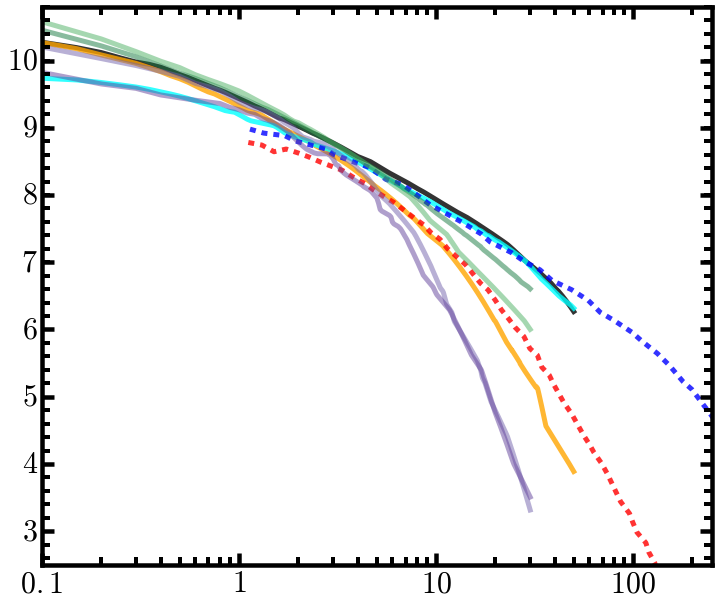

In [5]:
ax = plt.subplot(111)
ax.set_xscale("log", nonposy='clip')
ax = songPlotSetup(ax)

ax.plot(cgs_mprof_full['col1'], cgs_mprof_full['col2'], linestyle='-', c='k', 
        linewidth=5.0, alpha=0.8)
ax.plot(cgs_mprof_inner['col1'], cgs_mprof_inner['col2'], linestyle='-', c='orange',
        linewidth=5.0, alpha=0.8)
ax.plot(cgs_mprof_outer['col1'], cgs_mprof_outer['col2'], linestyle='-', c='cyan', 
        linewidth=5.0, alpha=0.8)

#ax.plot(10.0 ** cooper13_mprof_all['col1'], cooper13_mprof_all['col2'], 
#        linestyle='--', c='k')
ax.plot(10.0 ** cooper13_mprof_ins['col1'], cooper13_mprof_ins['col2'], 
        linestyle='--', c='r', linewidth=5.0, alpha=0.8)
ax.plot(10.0 ** cooper13_mprof_acc['col1'], cooper13_mprof_acc['col2'], 
        linestyle='--', c='b', linewidth=5.0, alpha=0.8)

#ax.plot(patel10_mprof['rkpc'], patel10_mprof['z0'], linestyle='-', c=GRN(0.9))
ax.plot(patel10_mprof['rkpc'], patel10_mprof['z1'], linestyle='-', c=GRN(0.8),
        linewidth=5.0, alpha=0.5)
#ax.plot(patel10_mprof['rkpc'], patel10_mprof['z2'], linestyle='-', c=GRN(0.7))
ax.plot(patel10_mprof['rkpc'], patel10_mprof['z3'], linestyle='-', c=GRN(0.6),
        linewidth=5.0, alpha=0.5)
#ax.plot(patel10_mprof['rkpc'], patel10_mprof['z4'], linestyle='-', c=PUR(0.6))
ax.plot(patel10_mprof['rkpc'], patel10_mprof['z5'], linestyle='-', c=PUR(0.7),
        linewidth=5.0, alpha=0.5)
ax.plot(patel10_mprof['rkpc'], patel10_mprof['z6'], linestyle='-', c=PUR(0.8),
        linewidth=5.0, alpha=0.5)

ax.set_xlim(0.1, 250.0)
ax.set_ylim(2.5, 10.8)

plt.show()

# Read in the Useful Catalogs

In [6]:
# Location of the data
homeDir = os.getenv('HOME')
sbpDir = os.path.join(homeDir, 'astro4/massive/dr15b/sbp/')

# Location for figures
figDir = os.path.join(sbpDir, 'figure')
# Location for subsamples
sampleDir = os.path.join(sbpDir, 'catalog')

# The SED models 
# 'fsps1', 'fsps2', 'fsps3', 'fsps4', 'bc03a'
sedMod = 'fsps1'
# 'imgsub', 'img'
sbpType = 'imgsub'

# Catalog files for BCG and NonBCG
redbcgStr = 'dr1_redbcg_isedfit_mass_' + sedMod + '_sbpsum_' + sbpType + '_use'
nonbcgStr = 'dr1_nonbcg_isedfit_mass_' + sedMod + '_sbpsum_' + sbpType + '_use'
redmemStr = 'dr1_redmem_isedfit_mass_' + sedMod + '_sbpsum_' + sbpType + '_use'

redbcgFile = redbcgStr + '.fits' 
nonbcgFile = nonbcgStr + '.fits' 
redmemFile = redmemStr + '.fits'

# Output
redbcgPrep = redbcgFile.replace('.fits', '_prep.fits')
nonbcgPrep = nonbcgFile.replace('.fits', '_prep.fits')
redmemPrep = redmemFile.replace('.fits', '_prep.fits')

try:
    redbcgTab
except NameError:
    pass
else:
    del redbcgTab     
try:
    nonbcgTab
except NameError:
    pass
else:
    del nonbcgTab
    
# Location for the SBP summary file
redbcgDir = os.path.join(sbpDir, 'redbcg')
nonbcgDir = os.path.join(sbpDir, 'nonbcg')
redmemDir = os.path.join(sbpDir, 'redmem')

# Two summary catalogs
redbcgCat = os.path.join(sampleDir, redbcgFile)
nonbcgCat = os.path.join(sampleDir, nonbcgFile)
redmemCat = os.path.join(sampleDir, redmemFile)

prefix1 = 'redbcg'
prefix2 = 'nonbcg'
prefix3 = 'redmem'

# Find and read in the catalogs
if not os.path.isfile(redbcgCat):
    raise Exception("## Can not find catalog for redBCG galaxies: %s" % redbcgCat)
else: 
    redbcgTab = Table.read(redbcgCat, format='fits')

if not os.path.isfile(nonbcgCat):
    raise Exception("## Can not find catalog for nonBCG galaxies: %s" % nonbcgCat)
else: 
    nonbcgTab = Table.read(nonbcgCat, format='fits')
    
if not os.path.isfile(redmemCat):
    raise Exception("## Can not find catalog for redmem galaxies: %s" % redmemCat)
else: 
    redmemTab = Table.read(redmemCat, format='fits')
    
print("## Deal with %i galaxies in redBCG sample" % len(redbcgTab))
print("## Deal with %i galaxies in nonBCG sample" % len(nonbcgTab))
print("## Deal with %i galaxies in redMem sample" % len(redmemTab))

## Deal with 300 galaxies in redBCG sample
## Deal with 11672 galaxies in nonBCG sample
## Deal with 1572 galaxies in redMem sample


In [8]:
redbcgLab1 = '$\Lambda > 20;\ \mathrm{CEN}$'
redbcgLab2 = '$\Lambda > 30;\ \mathrm{CEN}$'
nonbcgLab = '$\Lambda \leq 20;\ \mathrm{CEN}$'
redmemLab = '$\Lambda > 20;\ \mathrm{SAT}$'

In [7]:
# The CLEAN sample: 
redbcgClean = Table.read(os.path.join(sampleDir, redbcgFile.replace('.fits', '_clean.fits')), 
                         format='fits')
nonbcgClean = Table.read(os.path.join(sampleDir, nonbcgFile.replace('.fits', '_clean.fits')), 
                         format='fits')
redmemClean = Table.read(os.path.join(sampleDir, redmemFile.replace('.fits', '_clean.fits')), 
                         format='fits')

# The USE samples: 
redbcgUse = Table.read(os.path.join(sampleDir, redbcgFile.replace('.fits', '_use.fits')), 
                         format='fits')
nonbcgUse = Table.read(os.path.join(sampleDir, nonbcgFile.replace('.fits', '_use.fits')), 
                         format='fits')
redmemUse = Table.read(os.path.join(sampleDir, redmemFile.replace('.fits', '_use.fits')), 
                         format='fits')

# The GAMA sample
redbcgGama = Table.read(os.path.join(sampleDir, redbcgFile.replace('.fits', '_gama.fits')), 
                        format='fits')
nonbcgGama = Table.read(os.path.join(sampleDir, nonbcgFile.replace('.fits', '_gama.fits')), 
                        format='fits')

redbcgGamaZ = Table.read(os.path.join(sampleDir, redbcgFile.replace('.fits', '_gamaz.fits')), 
                         format='fits')
nonbcgGamaZ = Table.read(os.path.join(sampleDir, nonbcgFile.replace('.fits', '_gamaz.fits')), 
                         format='fits')